# Analysis of Earthquake Frequency
By Royce Schultz

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import curve_fit
from scipy.special import gamma

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [2]:
Fields = ['Date','Time','Latitude','Longitude','Type','Magnitude'] # Only import used columns
df = pd.read_csv('database.csv', usecols=Fields)

In [3]:
# Cleaning
df = df[df.Date.str.len() < 15] # Removes 3 rows with malformed dates
df = df[df.Type.isin(['Earthquake'])] # removes explosions and rock bursts

In [4]:
# Calculations
df['Datetime'] = pd.to_datetime(df.Date +' '+ df.Time)
df['Year'] = df['Datetime'].map(lambda x: x.year)

df['Rounded_Magnitude'] = np.floor(df.Magnitude * 2) / 2 #scaling rounds to the nearest half instad of whole number.

df['Last_Quake'] = df.Datetime.diff()
df = df[df['Last_Quake'].notna()]
df['Last_Quake_sec'] = df['Last_Quake'].map(lambda x: x.total_seconds()) # Last Quake (s)

df.reset_index(drop=True, inplace=True)

df.head()

,Date,Time,Latitude,Longitude,Type,Magnitude,Datetime,Year,Rounded_Magnitude,Last_Quake,Last_Quake_sec
0,01/04/1965,11:29:49,1.863,127.352,Earthquake,5.8,1965-01-04 11:29:49,1965,5.5,1 days 21:45:31,164731.0
1,01/05/1965,18:05:58,-20.579,-173.972,Earthquake,6.2,1965-01-05 18:05:58,1965,6.0,1 days 06:36:09,110169.0
2,01/08/1965,18:49:43,-59.076,-23.557,Earthquake,5.8,1965-01-08 18:49:43,1965,5.5,3 days 00:43:45,261825.0
3,01/09/1965,13:32:50,11.938,126.427,Earthquake,5.8,1965-01-09 13:32:50,1965,5.5,0 days 18:43:07,67387.0
4,01/10/1965,13:36:32,-13.405,166.629,Earthquake,6.7,1965-01-10 13:36:32,1965,6.5,1 days 00:03:42,86622.0


In [5]:
df.describe()

,Latitude,Longitude,Magnitude,Year,Rounded_Magnitude,Last_Quake,Last_Quake_sec
count,23228.000000,23228.000000,23228.000000,23228.000000,23228.000000,23228,23228.000000
mean,1.385304,39.738244,5.882785,1992.719520,5.728194,0 days 19:37:17.121146,70637.121147
std,29.929647,125.755664,0.424059,14.437895,0.402489,0 days 23:24:29.312558,84269.312559
min,-77.080000,-179.997000,5.500000,1965.000000,5.500000,0 days 00:00:00,0.000000
25%,-18.719500,-76.384500,5.600000,1981.000000,5.500000,0 days 03:39:22,13162.000000
50%,-3.684450,106.307500,5.700000,1994.000000,5.500000,0 days 11:42:44,42164.000000
75%,24.968500,145.290250,6.000000,2005.000000,6.000000,1 days 03:07:29.500000,97649.500000
max,86.005000,179.998000,9.100000,2016.000000,9.000000,10 days 05:30:13,883813.000000


In [6]:
len(df)

23228

## About the data

The dataset is available on [Kaggle](https://www.kaggle.com/usgs/earthquake-database)

The filtered set contains 23228 quakes with greater than 5.5 magnitude reported between 1965 and 2016.

There are **thousands** of small, unnoticable earthquakes every day that are not contained in this set.

## Does the strength of an earthquake depend on the time since the last earthquake?

**Hypothesis:** Assume the earth acts like a spring, constantly storing 'elastic' energy and releasing it in burst that we call earthquakes. Then big earthquakes are the result of a large buildup of energy. If an earthquake has not been recorded for a long time, the probability of a large quake is high.

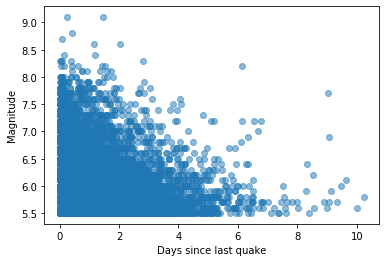

In [7]:
plt.scatter(df.Last_Quake_sec/(60*60*24),df.Magnitude, alpha=0.5)

plt.xlabel('Days since last quake')
plt.ylabel('Magnitude')
plt.show()

## Big quakes are preceeded shortly by other quakes
The hypothesis is **not supported**. In fact, the longer time without a quake, the higher probability that the next quake will be small.

However, this graph does not account for other factors like location and therefore the hypothesis cannot be proved inncorrect.

## Earthquakes are random

Even leading science cannot precisly predict earthquakes, however the frequency of earthquakes can still be modeled statistically. The following figure shows a histogram chart of the time between each recorded quake.

Text(0.5, 0, 'Time since last Quake (days)')

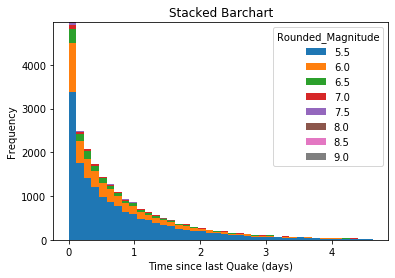

In [8]:
(df[df.Last_Quake_sec < 4*10**5].pivot(columns='Rounded_Magnitude')['Last_Quake_sec']/(60*60*24)).plot(kind = 'hist', stacked=True,bins=40)

plt.title('Stacked Barchart')
plt.xlabel('Time since last Quake (days)')

## The Exponential Distribution
This shape should look familiar to any engineer. It is a decaying exponential. The exponential is a common and well understood distribution. The cumulative and marginal distributions are defined as such,

In [9]:
def cumulative_density(x, lamb): # The integral of MDF
    return 1 - np.exp(-lamb * x)

def marginal_density(x, lamb): # The derivative of CDF
    return lamb * np.exp(-lamb * x)

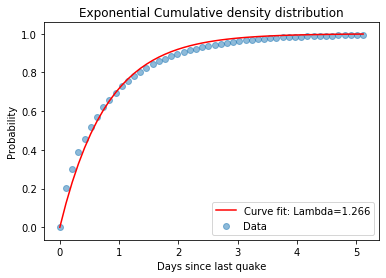

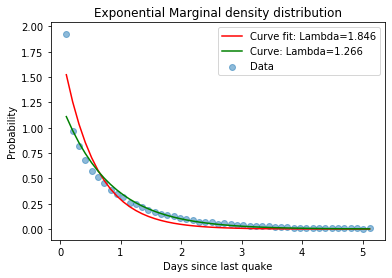

In [10]:
# Fit functions to observed data

density = 50 # Plot resolution

# Cumulative Distribution
max_x = df.Last_Quake_sec.max() / (24*60*60)
x = np.linspace(0,.5*max_x,density)
y = np.linspace(0,0,density)
for i in range(density):
    y[i] = len(df[df.Last_Quake_sec < 24*60*60*x[i]]) / len(df)

plt.scatter(x,y, alpha=0.5, label='Data')

popt, pcov = curve_fit(cumulative_density, x, y)
plt.plot(x, cumulative_density(x, *popt), 'r-',label='Curve fit: Lambda=%5.3f' % tuple(popt))

plt.title('Exponential Cumulative density distribution')
plt.xlabel('Days since last quake')
plt.ylabel('Probability')
plt.legend()

#Marginal Distribution
plt.figure()
dx = np.diff(x)
dy = np.diff(y)
new_x = x[1:]

plt.scatter(new_x,dy/dx, alpha=0.5, label='Data')

popt, pcov = curve_fit(marginal_density, new_x, dy/dx)
plt.plot(new_x, marginal_density(new_x, *popt), 'r-',label='Curve fit: Lambda=%5.3f' % tuple(popt))
plt.plot(new_x, marginal_density(new_x, 1.266), 'g-',label='Curve: Lambda=1.266')

plt.title('Exponential Marginal density distribution')
plt.xlabel('Days since last quake')
plt.ylabel('Probability')
plt.legend()

plt.show()

Lets use
\begin{align}
\lambda = 1.266
\end{align}

The exponential distribution has the propterty,

\begin{align}
mean = \frac{1}{\lambda} \\
variance = \frac{1}{\lambda}
\end{align}

So, **on average** earthquakes occour every 0.789 days.

This closely agreees with the calculated mean of the dataset with only 3.4% error.

In [11]:
(df.Last_Quake_sec/(24*60*60)).mean() # Calculated mean

0.8175592725334686

This exponential distribution models the **rate of events**, however it is often more useful to predict the **number of events** in a time period. This is modeled using a sum of exponential distributions that shall be left to the reader to prove. This distribution is commonly refered to as the Poisson Distribution.

## The Poisson Distribution
The Poisson distribution describes the probability of **k** number of events within the time frame.

In [12]:
def pois_marginal_density(k,lamb):
    a = lamb**k
    b = np.exp(-lamb)
    c = np.zeros(len(k))
    c = gamma(k+1)
    return (a * b) / c

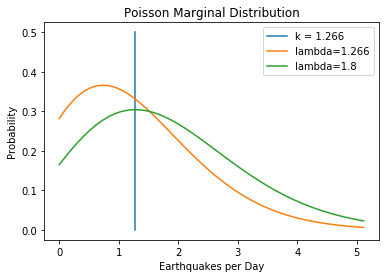

In [13]:
lamb = 1.266
x = np.linspace(0,.5*max_x) 
plt.plot([lamb,lamb],[0,.5], label='k = 1.266') # Mark mean
plt.plot(x,pois_marginal_density(x,lamb),label = 'lambda=1.266')

lamb = 1.8
plt.plot(x,pois_marginal_density(x,lamb),label='lambda=1.8')

plt.title('Poisson Marginal Distribution')
plt.xlabel('Earthquakes per Day')
plt.ylabel('Probability')
plt.legend()

The Poisson distribution has the propterty,

\begin{align}
mean = \lambda \\
variance = \lambda
\end{align}

So, **on average** earth will have 1.2 eathquakes per day

# Are earthquakes uniformily distributed around the globe?

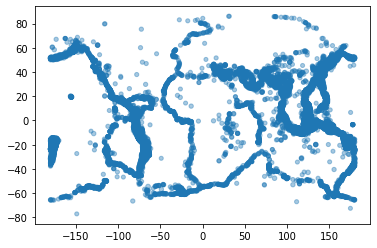

In [14]:
plt.scatter(df.Longitude.values,df.Latitude.values, alpha=0.4, s=3*df.Magnitude.values)

This scatterplot shows the Latitude and Longitude coordinates of each quake in the dataset. The set clearly outlines the tectonic plates.

![Tectonic Plates Map](tectonic-plates.jpg)

# Which city has greater danger of earthquakes: San Francisco or Tokyo?

This requires aggregating data by distance from a reference point. Some functions need to be defined first.

## About the distance Funciton
Subtracting latitude and longitude of a quake will not return the distance. This is the same effect that makes Greenland appear nearly as large as Africa on a 2d map.
    
Instead Lat/Long points in spherical space are converted to an x,y,z triple in cartesian space. Then the euclidian distance between quakes and the reference point can be accuratly calculated.
    
 This method should more accuratly assess the proximity of the earthquake since the energy waves travel in a (nearly) straight line through the crust, not along the surface. It should be noted that this does not apply to earthquakes on the opposite side of the earth as the waves do not travel through earths molten core.


In [15]:
# Description:
#   Determines Euclidian (straight line) between 2 points. Does not consider arc length, just straight distance
#   Assumes earth is a sphere with radius=1
#   So the poles are 2 units apart, the equator is sqrt(2) from each pole, not pi and pi/2
# Input:
#   Dataframe with Latitude and Longitude components
#   2 arguments for Lat and Long of reference point
# Output:
#   Series containing distances to the reference point

def distance_from(df, Lat, Long):
    
    Lat = np.deg2rad(Lat) # Convert degrees to radians for numpy trig
    Long = np.deg2rad(Long)
    x_pos = np.cos(Lat)*np.sin(Long) # Convert spherical coordinates to cartesian
    y_pos = np.cos(Lat)*np.cos(Long) # Assumes earths radius = 1
    z_pos = np.sin(Lat)
    
    data_Latitude_rad = np.deg2rad(df.Latitude) # Convert dataframe to radians
    data_Longitude_rad = np.deg2rad(df.Longitude)
    data_x_pos = np.cos(data_Latitude_rad)*np.sin(data_Longitude_rad) # Convert to spherical
    data_y_pos = np.cos(data_Latitude_rad)*np.cos(data_Longitude_rad)
    data_z_pos = np.sin(data_Latitude_rad)
    return ( (data_x_pos - x_pos)**2 + (data_y_pos - y_pos)**2 + (data_z_pos - z_pos)**2)**(1/2) # Pythagoras3D

In [16]:
Tokyo = [35.67,139.65]
San_Fran = [37.77,-122.42]
Denver = [39.74,-104.99]

df['Dist_Tokyo'] = distance_from(df,Tokyo[0],Tokyo[1])
df['Dist_San_Fran'] = distance_from(df,San_Fran[0],San_Fran[1])
df['Dist_Denver'] = distance_from(df,Denver[0],Denver[1])

df.reset_index(drop=True, inplace=True)

df.head()

,Date,Time,Latitude,Longitude,Type,Magnitude,Datetime,Year,Rounded_Magnitude,Last_Quake,Last_Quake_sec,Dist_Tokyo,Dist_San_Fran,Dist_Denver
0,01/04/1965,11:29:49,1.863,127.352,Earthquake,5.8,1965-01-04 11:29:49,1965,5.5,1 days 21:45:31,164731.0,0.612724,1.583197,1.702209
1,01/05/1965,18:05:58,-20.579,-173.972,Earthquake,6.2,1965-01-05 18:05:58,1965,6.0,1 days 06:36:09,110169.0,1.166416,1.228930,1.390338
2,01/08/1965,18:49:43,-59.076,-23.557,Earthquake,5.8,1965-01-08 18:49:43,1965,5.5,3 days 00:43:45,261825.0,1.949312,1.782142,1.726013
3,01/09/1965,13:32:50,11.938,126.427,Earthquake,5.8,1965-01-09 13:32:50,1965,5.5,0 days 18:43:07,67387.0,0.459641,1.518147,1.635202
4,01/10/1965,13:36:32,-13.405,166.629,Earthquake,6.7,1965-01-10 13:36:32,1965,6.5,1 days 00:03:42,86622.0,0.928365,1.334940,1.501385


# How far away can you feel a strong quake?
The [US Geological Program (USGS)](https://earthquake.usgs.gov/learn/topics/mag-intensity/) cites that even somewhat large earhquakes dissapate quickly over an area. The tremors can hardly be felt more than just 100km or about 1 degree away.

![Quake Strength Map](Quake_Strength_Heatmap.jpg)

There are clearly other factors to consider before estimating damages. Soil composition can affect energy dissapation and other secondary effects like tsunamis can cause significant damage from greater distances.

## Calculating the local distance threshold

More precicely, 100km == 0.899 deg, but lets round up to 1 degree

In [17]:
# Uses the radius of the earth to calculate the arc of 100 km
earth_radius = 6371 # kilometers
earth_circumfrence = earth_radius * 3.14 * 2
km_per_deg = earth_circumfrence / 360
print(100/km_per_deg)

0.8997777548945409


1 degree maps to 0.017 in the distance space.

In [18]:
# Calculates distance between Lat/Long points (0,0) and (0,1)
q = pd.DataFrame.from_dict({'Latitude': [0], 'Longitude': [0]})
distance_from(q,0,1)

0    0.017453
dtype: float64

For reference, the distance between SF and LA is 0.088

In [19]:
# Calculate the distance (in the arbitrary distance space) between SF and LA
q = pd.DataFrame.from_dict({'Latitude': [San_Fran[0]], 'Longitude': [San_Fran[1]]})
distance_from(q,34.05,-118.24) # Distance to LA

0    0.08774
dtype: float64

## Comparing the frequency of earthquakes in 3 large cities.

Text(0.5, 1.0, 'Large earthquakes per year (avg)')

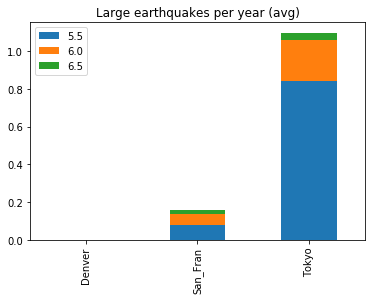

In [20]:
Local_Dist = .017
years = 2016-1965

Denver_Local_Counts = df[df.Dist_Denver < Local_Dist].Rounded_Magnitude.value_counts() / years
San_Fran_Local_Counts = df[df.Dist_San_Fran < Local_Dist].Rounded_Magnitude.value_counts() / years
Tokyo_Local_Counts = df[df.Dist_Tokyo < Local_Dist].Rounded_Magnitude.value_counts() / years

counts = pd.concat({'Denver':Denver_Local_Counts, 'San_Fran':San_Fran_Local_Counts, 'Tokyo':Tokyo_Local_Counts}, axis = 1).fillna(0)
counts.transpose().plot(kind='bar',stacked=True)

plt.title('Large earthquakes per year (avg)')


## Tokyo has significantly more earthquakes than San Francisco or Denver

Traditionally, buildings in Tokyo were made of wood becuase the wood flexes during earthquakes instead of crumbling like bricks or concrete. However, wood building cause other forms of danger. In 1923, a **8.3** magnitude earthquake hit Tokyo. A fire had broken out in one of the wooden buildings and quickly spread throughout the city killing 142,000 people, more than the earthquake itself. ([source](https://historycollection.co/day-history-great-tokyo-fire-devastates-city-1923/))

Modern structures in Tokyo use elaborate damping methods to dissapate energy as it travels through the building.

![Dampers](damper.jpg)

Other solutions completely isolate the building from the ground by sitting on rollers.

![Rollers](rollers.jpg)

## San Francisco must prepare for a large quake

Although quakes in San Francisco are less common, they are not safe and currently do not have the infractructure to protect large structures and residents like Tokyo does. Furthermore, the probability of liquefaction, where the ground shows fluid properties when shaken, is very high across the San Francisco peninsula due to the sandy soil composition.

![Liquefaction Map](liquefaction.png)
([source,  NY Times](https://www.nytimes.com/interactive/2018/04/17/us/san-francisco-earthquake-seismic-gamble.html))